Deliverable 1 - 

The goal of the Kaggle Cancer CNN mini-project is to develop a CNN model to accurately classify images of metastatic cancer in small image patches. The project utilizes the CNN machine learning method to accomplish this task, and the necessary data is downloaded from the Kaggle website at https://www.kaggle.com/c/histopathologic-cancer-detection.

The data is composed of images that are named with an image ID, and a positive label indicates that a patch of one pixel has tumor tissue. However, it is important to note that the data contains duplicates. In order to properly analyze and model this data, the EDA (Exploratory Data Analysis) process involves removing the duplicate images and reviewing the label quality with a histogram.

After cleaning the data, the next step is to develop the CNN model and tune it to improve its ability to generalize. This involves training the model on the cleaned data and experimenting with different hyperparameters to increase the accuracy of the model.

Once the model is trained, the project reviews its accuracy and evaluates its overall performance. This provides insight into the effectiveness of the CNN model for classifying images of metastatic cancer in small image patches.

In conclusion, the Kaggle Cancer CNN mini-project demonstrates the ability to accurately classify images of metastatic cancer using a CNN model. Through careful cleaning and analysis of the data, the project provides a valuable example of how to develop and train a CNN model for real-world applications.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
id       0
label    0
dtype: int64


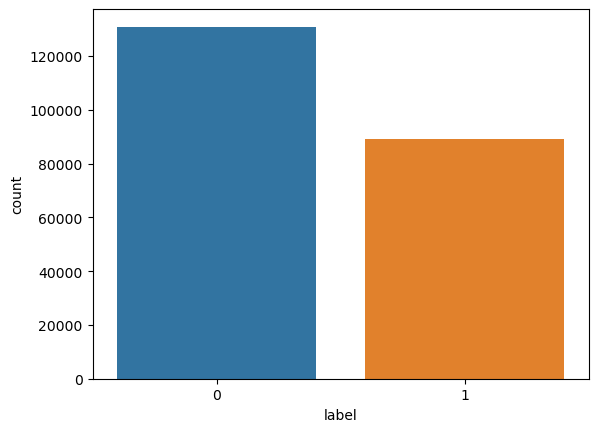

/home/olu/miniconda3/envs/rapids-23.08/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


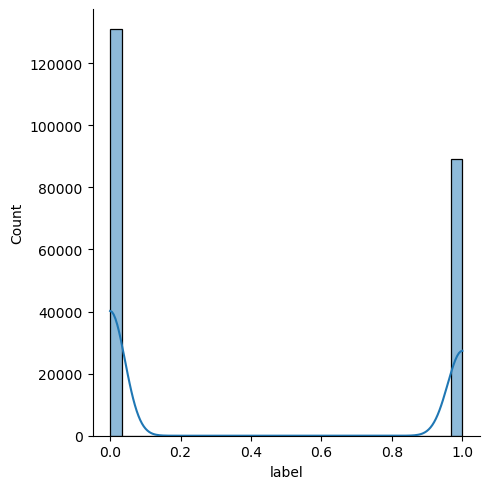

In [8]:
#1
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import cudf as pd
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim



data = pd.read_csv("/home/olu/Desktop/CNNKaggle/histopathologic-cancer-detection/train_labels.csv")


print(data.head())
print(data.describe())
print(data.isnull().sum())
sns.countplot(x="label", data=data)
plt.show()
sns.displot(data, x="label", kde=True)
plt.show()


based on number of training dataset.  I am going to split the data into train and validation.   I am going to validate the performance of the training steps. Then I will complete the prediction of the test dataset for kaggle submission.

In [9]:
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

Number of available GPUs: 1


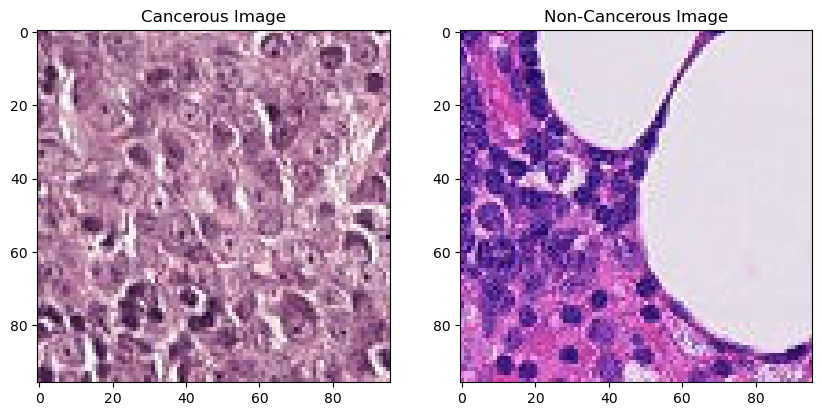

In [10]:
#Load labels
data = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')

# a cancer image
cancerous_image = data[data['label'] == 1].sample(1)
cancerous_image_path = "./histopathologic-cancer-detection/train/" + cancerous_image['id'].values[0] + ".tif"
cancerous_image_data = plt.imread(cancerous_image_path)

# noncancer image
non_cancerous_image = data[data['label'] == 0].sample(1)
non_cancerous_image_path = "./histopathologic-cancer-detection/train/" + non_cancerous_image['id'].values[0] + ".tif"
non_cancerous_image_data = plt.imread(non_cancerous_image_path)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cancerous_image_data)
ax[0].set_title('Cancerous Image')
ax[1].imshow(non_cancerous_image_data)
ax[1].set_title('Non-Cancerous Image')
plt.show()


In [11]:
DATA_DIR = './histopathologic-cancer-detection/'
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 4
EPOCHS = 10
rate = 0.0001
test_predictions = []
image_ids = []
torch.manual_seed(SEED)

class CustomDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        self.file_names = dataframe['id'].values
        self.labels = dataframe['label'].values if 'label' in dataframe.columns else None

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.file_names[idx])
        if not os.path.exists(img_path):  # Optional check
            raise FileNotFoundError(f"No such file: '{img_path}'")
        
        with Image.open(img_path).convert("RGB") as img:
            if self.transform:
                image = self.transform(img)
                
        if self.labels is not None:
            label = int(self.labels[idx])
            return image, label
        else:
            return image

data = pd.read_csv(DATA_DIR + 'train_labels.csv')
data['id'] = data['id'] + '.tif'

train_labels, val_labels = train_test_split(data, test_size=0.7, stratify=data['label'], random_state=SEED)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Changing the size can affect the output shape
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Matching the input size with the train transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_labels, os.path.join(DATA_DIR, 'train'), train_transform)
val_dataset = CustomDataset(val_labels, os.path.join(DATA_DIR, 'train'), val_transform)



test_image_files = [f for f in os.listdir(os.path.join(DATA_DIR, 'test/')) if f.endswith('.tif')]
test_dataframe = pd.DataFrame({'id': test_image_files})
test_dataset = CustomDataset(test_dataframe, os.path.join(DATA_DIR, 'test/'), val_transform)
#test_dataset = CustomDataset(test_dataframe, os.path.join(DATA_DIR, 'test/'), val_transform)  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [19]:
#pytorch model
# Constants
SEED = 42
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 10
rate = 0.001
DATA_DIR = './histopathologic-cancer-detection/'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #self.classifier = nn.Sequential(
        #    nn.Flatten(),
        #    nn.Linear(12*12*128, 128),
        #    nn.ReLU(),
        #    nn.Dropout(0.5),
        #    nn.Linear(128, 1),
        #    nn.Sigmoid()
        #)
        self.classifier = nn.Sequential(
            nn.Linear(100352, 128),  
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

#Nvidia GPU
device = torch.device("cuda") 
print("Training on", device)


model = CNN().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=rate)
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1).float()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
        predicted_train = torch.round(outputs).view(-1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels.view(-1)).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1} loss: {train_losses[-1]}, accuracy: {train_accuracies[-1]}%")


correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        predicted = torch.round(outputs).view(-1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation accuracy: {val_acc}%")


Training on cuda
Epoch 1 loss: 0.46589502236447866, accuracy: 78.9643522656688%
Epoch 2 loss: 0.4110990115235976, accuracy: 82.104928265184%
Epoch 3 loss: 0.39301401151364945, accuracy: 83.05634250912782%
Epoch 4 loss: 0.37406813318990584, accuracy: 83.96382201887678%
Epoch 5 loss: 0.36770417887610946, accuracy: 84.45922402169467%
Epoch 6 loss: 0.3580005926468739, accuracy: 84.79555198691048%
Epoch 7 loss: 0.3523742302356561, accuracy: 85.06219037374824%
Epoch 8 loss: 0.34983329850524825, accuracy: 85.16823973214962%
Epoch 9 loss: 0.3439413476617979, accuracy: 85.65909676246459%
Epoch 10 loss: 0.34302393628724037, accuracy: 85.5485024315603%
Validation accuracy: 87.72610993520237%


After split the dataset, my approach is to develop two sections to the problem.  One the feature extraction and the other is the classification component. The feature extraction has 3 CNNlayers. I used a ReLU activation to help speed up the traning  process. The classification flattens the feature  and passes them through two dense layers, incorporating a ReLU activation, dropout for regularization, and finally producing a single output via a sigmoid activation, presumably for binary classification.
I used the available GPU to speed up the training has i was dealing with a lot of images.  

Instead of just ResNet50, maybe I should have tried other ResNet version with a similar way. Adjust the grid search parameters accordingly.

**Improve Training Performance**

1. Constantly adjusting the learning rate during training.
2. Augmentation of the data to improve data diversity.
3. Stop training when the validation loss stops improving.


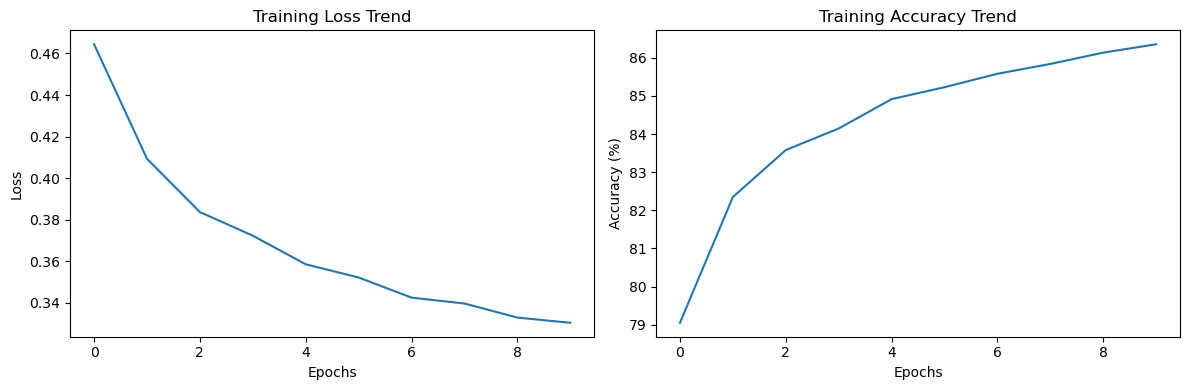

In [13]:
#Present Results with Tables and Visual Representations
# Plotting training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Here are several things I could try to improve the accuracy of this CNN model:

1. Increase the depth of the model by adding more convolutional and pooling layers.

2. Use a larger kernel size for the convolutional layers to capture more global features.

3. Add regularization to prevent overfitting, such as L2 regularization or dropout.

4. Use a different optimizer, such as SGD or RMSprop, and tune the learning rate.

5. Use data augmentation techniques, such as random rotation, shear, zoom, and shift, to increase the size of the training set, this would allow better generalization of the model.

6. Increase the size of the images by using a larger target_size parameter.  This would acually require a GPU as it took over 2 hours to train this CNN.

7. Try different architectures, such as ResNet or Inception, to see if they perform better.

8. Fine-tune the pre-trained weights of a pre-trained model, such as VGG16 or MobileNet, on the current dataset.

9. Increase the number of epochs to allow the model to learn more complex patterns in the data.

In [14]:
test_dataset[0]

tensor([[[2.1119, 2.2489, 2.2318,  ..., 2.1975, 2.1975, 2.1975],
         [2.0605, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.1975],
         [2.0948, 2.2489, 2.2147,  ..., 2.1975, 2.1975, 2.1975],
         ...,
         [1.2899, 2.1633, 1.9235,  ..., 1.7694, 2.1804, 2.2318],
         [1.3413, 2.1975, 1.8550,  ..., 1.5125, 2.1462, 2.2489],
         [1.3584, 2.0948, 1.8893,  ..., 1.4612, 1.9749, 2.1119]],

        [[2.0259, 2.2185, 2.1835,  ..., 2.3761, 2.3761, 2.3761],
         [1.9909, 2.2535, 2.2010,  ..., 2.3761, 2.3761, 2.3761],
         [1.9384, 2.1485, 2.1134,  ..., 2.3761, 2.3761, 2.3761],
         ...,
         [0.9580, 1.8859, 1.6408,  ..., 1.8333, 2.2535, 2.3060],
         [1.0105, 1.9384, 1.5882,  ..., 1.5707, 2.2185, 2.3235],
         [0.9930, 1.7808, 1.6057,  ..., 1.5182, 2.0434, 2.2010]],

        [[2.4831, 2.6226, 2.5703,  ..., 2.5877, 2.5877, 2.5877],
         [2.4308, 2.6051, 2.5529,  ..., 2.5877, 2.5877, 2.5877],
         [2.3960, 2.5529, 2.4831,  ..., 2.5877, 2.5877, 2.

In [17]:
# Changing the hyperparameters 

SEED = 42
BATCH_SIZE = 16
NUM_WORKERS = 8
EPOCHS = 20
rate = 0.001
DATA_DIR = './histopathologic-cancer-detection/'



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(100352, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#Nvidia GPU
device = torch.device("cuda")  
print("Training on", device)


model = CNN().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=rate)


train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1).float()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
        predicted_train = torch.round(outputs).view(-1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels.view(-1)).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1} loss: {train_losses[-1]}, accuracy: {train_accuracies[-1]}%")


correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        predicted = torch.round(outputs).view(-1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation accuracy: {val_acc}%")


with torch.no_grad():
    for i, (inputs) in enumerate(test_loader):  
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        predicted = torch.round(outputs).view(-1).cpu().numpy().astype(int)
        
        
        predicted_list = predicted.tolist()
        test_predictions.extend(predicted_list)
        
        
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + len(inputs)
        
        #batch_id = test_loader.dataset.id[start_idx:end_idx].tolist()
        
        batch_id = test_loader.dataset.file_names[start_idx:end_idx].tolist()


        
        # Save ids
        image_ids.extend(batch_id)


#kaggle CSV
df = pd.DataFrame({
    'id': image_ids,
    'label': test_predictions
})

df['id'] = df['id'].str.replace('.tif', '', regex=False)
df.to_csv('predictions.csv', index=False)



Training on cuda
Epoch 1 loss: 0.4666925456575323, accuracy: 79.00374202736073%
Epoch 2 loss: 0.4093364354221207, accuracy: 82.17916281606496%
Epoch 3 loss: 0.3868672907265771, accuracy: 83.30783098762252%
Epoch 4 loss: 0.3749066394470701, accuracy: 83.89261744966443%
Epoch 5 loss: 0.3643223869059482, accuracy: 84.6349629584741%
Epoch 6 loss: 0.36094090927589073, accuracy: 84.58193827927342%
Epoch 7 loss: 0.36019460771321327, accuracy: 84.8561516202827%
Epoch 8 loss: 0.3516062352764797, accuracy: 85.12430499795477%
Epoch 9 loss: 0.3489606693943207, accuracy: 85.31367885224294%
Epoch 10 loss: 0.34446809324560035, accuracy: 85.64091687245292%
Epoch 11 loss: 0.3404817679121375, accuracy: 85.67121668913903%
Epoch 12 loss: 0.3407489005340804, accuracy: 85.5803172390807%
Epoch 13 loss: 0.3370105798780138, accuracy: 85.81665580923236%
Epoch 14 loss: 0.33466495472036745, accuracy: 85.93331010347387%
Epoch 15 loss: 0.3335878425361286, accuracy: 86.08783916857303%
Epoch 16 loss: 0.33298361809925

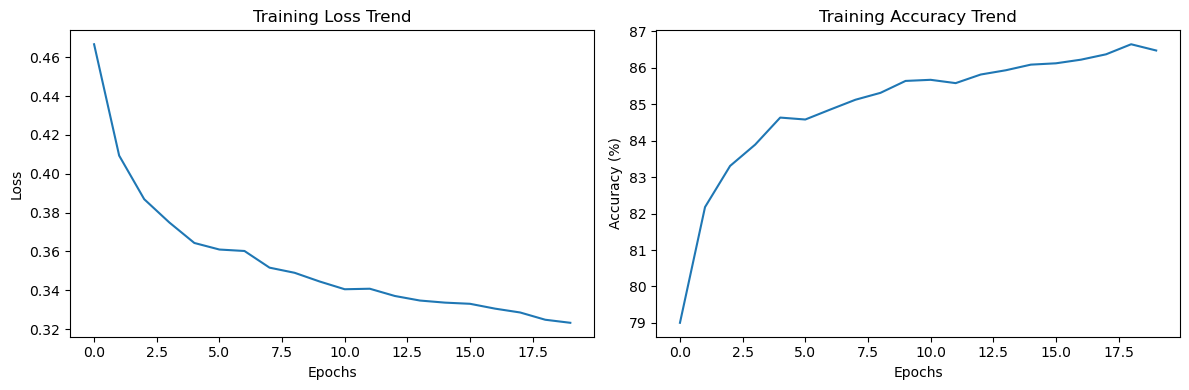

In [18]:
#Present Results with Tables and Visual Representations
# Plotting training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Conclusion

The optimizer and the batch size with learning rates affect the convergence rate. From the analysis above.  There are several ways this project could be optimized to improve score. The image transformation was helpful, however, the model achiecture can be changed multiple times like using RESNET18 or other versions.  Like using a transformer for image classification. 

Need more mlflow type tools and other assests to improve perfomance. 

Deliverables

1. Jupyter Notebook 
2. Public GitHub repo of project. 
3. README file to explain the jupyter notebook
4. Screenshot of leaderboard position on the Kaggle